# Siamese Network

This method is based on the idea that combining characteristics from both eyes can improve the predictions for Diabetic retinopathy (DR) grading since DR-related alterations frequently occur in both eyes, although to differing degrees. This network has two principal components - the feature extraction branch and the classification head. The feature extraction is conducted using two branches of the pre-trained EfficientNet model. These branches are identical in structure but operate independently, processing the left and right eye images separately. The classification head of our network is a custom-designed neural network built on top the feature extraction branches. The Siamese Network is trained to combine the features from both eyes using learnable weights. These weights are crucial as they allow the model to dynamically adjust the influence of each eye’s features based on their relevance to DR grading.

**Note:** We highly recommend running this notebook on a GPU. 

## 0. Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import os

os.chdir("..")
import requests
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from src.utils import seed_everything, calculate_metrics
from sklearn.metrics import confusion_matrix
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from src.models.siamese_net import SiameseNetwork
from src.loading import load_data, load_test_data
from src.train import train_siamese

In [4]:
# Set the seeds
seed_everything()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



---

<a name='s1'></a>
## 1. Downloading the dataset

Fetching the dataset should take around 4-5 minutes. Unzipping takes 20s.

In [5]:
# if folder 'data/' is does not exist, download the data
if not os.path.exists("data/"):
    # Dropbox URL
    dropbox_url = "https://www.dropbox.com/scl/fi/sa14unf8s47e9ym125zgo/data.zip?rlkey=198bg0cmbmmrcjkfufy9064wm&dl=1"

    # File path where the .zip file will be saved
    file_path = "data.zip"

    response = requests.get(dropbox_url)

    if response.status_code == 200:
        with open(file_path, "wb") as file:
            file.write(response.content)
        message = "Download successful. The file has been saved as 'data.zip'."
    else:
        message = "Failed to download the file. Error code: " + str(
            response.status_code
        )

    print(message)

    # Path to the downloaded .zip file
    zip_file_path = "data.zip"

    # Directory to extract the contents of the zip file
    extraction_path = ""

    # Unzipping the file
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(extraction_path)

    extraction_message = (
        f"The contents of the zip file have been extracted to: {extraction_path}"
    )

    print(extraction_message)

## 2. Data

Load the data with improved preprocessing. Set the batch size according to your machine, here we tried to set it as high as possible, as long as the GPU/CPU has enough memory.

In [6]:
# Load the .jpeg files in the data folder
PATH_IMAGES = "data/images_keep_ar"
PATH_LABELS = "data/labels/trainLabels.csv"
MODEL = "results/models/eff_net_400x400.pt"  # change
MODEL_SIAMESE = "results/models/siamese_net_400x400_2.pt"  # change

batch_size = 16
img_size = (400, 400)  # default size 120/120
num_epochs = 20

When loading the data for the siamese network the parameter shuffle should be equal to `False` so the images are in correct order. `False` is set by default, this can be altered in load_data function.

In [7]:
train_loader, validation_loader = load_data(
    PATH_LABELS, PATH_IMAGES, img_size, batch_size
)

Number of train samples:31964
Number of validation samples:3162


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


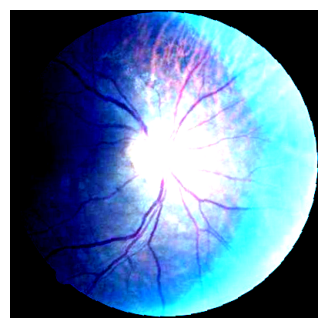

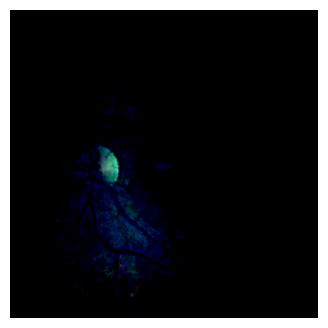

In [8]:
# visualzie a batch of images
for image, labels in train_loader:
    plt.figure(figsize=(4, 4))
    plt.axis("off")
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

    plt.figure(figsize=(4, 4))
    plt.axis("off")
    plt.imshow(np.transpose(image[1], (1, 2, 0)))
    plt.show()
    break

## 3. Model

Initialize and load the pretrained EfficientNet

In [9]:
# Initialize model with the best available weights
weights = EfficientNet_B3_Weights.DEFAULT
model = efficientnet_b3(weights=weights)

# Freeze all layers as we will train only the neural network on top
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1536, out_features=5, bias=True),
)  # Have to define in order to load the weights

model.load_state_dict(torch.load(MODEL))

<All keys matched successfully>

Define the classifier on top. The size is 1536 * 2 since the input is two vectors, `[primary_eye, secondary_eye]`.

In [ ]:
classifier = nn.Sequential(
    nn.BatchNorm1d((1536) * 2),
    nn.Linear((1536) * 2, 500),
    nn.BatchNorm1d(500),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(500, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(100, 5),
)

model.classifier = nn.Identity()
siamese_net = SiameseNetwork(model, classifier)

In [ ]:
class_weights = torch.tensor([73.48, 3.0, 15.06, 2.49, 2.02])  # distribution of classes

# Inversely proportional weights
weights = 1.0 / class_weights
weights = weights / weights.sum()
weights = weights.to(device)

optimizer = optim.Adam(siamese_net.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(weight=weights)
siamese_net.to(device)
siamese_net.load_state_dict(torch.load(MODEL_SIAMESE))

### 3.1 Model training and evaluation

In [ ]:
train_siamese(
    siamese_net,
    train_loader,
    validation_loader,
    criterion,
    optimizer,
    device,
    model_name="results/models/siamese_net_400x400_3.pt",
    num_epochs=num_epochs,
)

## 4. Submission

The following code is for generating a submission file

In [9]:
MODEL_SIAMESE = "results/models/siamese_net_400x400_3.pt"
MODEL = "results/models/eff_net_400x400.pt"

# Define Backbone
weights = EfficientNet_B3_Weights.DEFAULT
model = efficientnet_b3(weights=weights)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1536, out_features=5, bias=True),
)
model.load_state_dict(torch.load(MODEL))
model.classifier = nn.Identity()

# freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Define Siamese Network
classifier = nn.Sequential(
    nn.BatchNorm1d((1536) * 2),
    nn.Linear((1536) * 2, 500),
    nn.BatchNorm1d(500),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(500, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(100, 5),
)
siamese_net = SiameseNetwork(model, classifier)
siamese_net.load_state_dict(torch.load(MODEL_SIAMESE))
siamese_net.to(device)
siamese_net.eval()

SiameseNetwork(
  (branch): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (sca

In [10]:
img_size = (400, 400)
batch_size = 32
test = load_test_data("data/test/", img_size, batch_size)

Plot a images to check if they are in the correct order

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


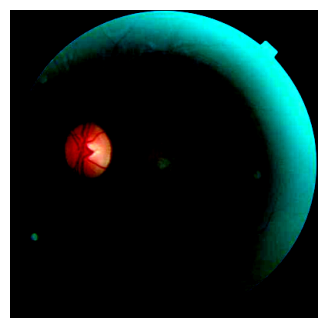

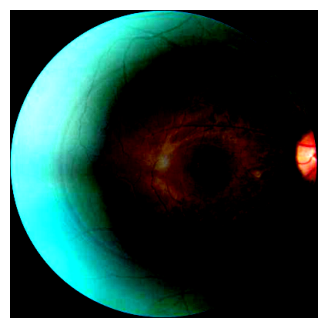

In [11]:
for image, base_name in test:
    plt.figure(figsize=(4, 4))
    plt.axis("off")
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

    plt.figure(figsize=(4, 4))
    plt.axis("off")
    plt.imshow(np.transpose(image[1], (1, 2, 0)))
    plt.show()
    break

In [ ]:
# Test loop
siamese_net.eval()
test_preds = []
test_names = []
with torch.no_grad():
    for images, names in tqdm(test):
        images = images.to(device)

        left_images = images[::2]
        right_images = images[1::2]

        outputs_left, outputs_right = siamese_net(left_images, right_images)

        predicted_left = outputs_left.argmax(dim=1)
        predicted_right = outputs_right.argmax(dim=1)

        test_preds.extend(predicted_left.cpu().numpy())
        test_preds.extend(predicted_right.cpu().numpy())
        test_names.extend(names[::2])
        test_names.extend(names[1::2])

## 5. Analysis

Load the pretrained model

In [34]:
MODEL_SIAMESE = "results/models/siamese_net_400x400_2.pt"
MODEL = "results/models/eff_net_400x400.pt"

# Define Backbone
weights = EfficientNet_B3_Weights.DEFAULT
model = efficientnet_b3(weights=weights)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1536, out_features=5, bias=True),
)
model.load_state_dict(torch.load(MODEL))
model.classifier = nn.Identity()

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Define Siamese Network
classifier = nn.Sequential(
    nn.BatchNorm1d((1536) * 2),
    nn.Linear((1536) * 2, 500),
    nn.BatchNorm1d(500),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(500, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(100, 5),
)
siamese_net = SiameseNetwork(model, classifier)
siamese_net.load_state_dict(torch.load(MODEL_SIAMESE))
siamese_net.to(device)
siamese_net.eval()

SiameseNetwork(
  (branch): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (sca

In [35]:
# Validation loop
siamese_net.eval()
validation_preds, validation_labels, validation_outputs = [], [], []
for images, labels in tqdm(validation_loader):
    images, labels = images.to(device), labels.to(device)
    left_images = images[::2]  # This will take images 0, 2, 4, 6
    right_images = images[1::2]  # This will take images 1, 3, 5, 7
    left_labels = labels[::2]
    right_labels = labels[1::2]

    outputs_left, outputs_right = siamese_net(left_images, right_images)

    predicted_left = outputs_left.argmax(dim=1)
    predicted_right = outputs_right.argmax(dim=1)

    validation_outputs.extend(outputs_left.detach().cpu().numpy())
    validation_outputs.extend(outputs_right.detach().cpu().numpy())
    validation_preds.extend(predicted_left.cpu().numpy())
    validation_preds.extend(predicted_right.cpu().numpy())
    validation_labels.extend(left_labels.cpu().numpy())
    validation_labels.extend(right_labels.cpu().numpy())

# calculate metrics for the test data
validation_metrics = calculate_metrics(validation_labels, validation_preds)
print("Validation accuracy: ", validation_metrics["accuracy"])
print("Validation kappa score: ", validation_metrics["quadratic_kappa"])
print("Validation f1 score: ", validation_metrics["f1_score"])
print("Validation recall: ", validation_metrics["recall"])
print("Validation precision: ", validation_metrics["precision"])
print("---------------")

  0%|          | 0/198 [00:00<?, ?it/s]

100%|██████████| 198/198 [00:41<00:00,  4.78it/s]

Validation accuracy:  0.6998734977862112
Validation kappa score:  0.6881523642197862
Validation f1 score:  0.5218875786012903
Validation recall:  0.5347266318693805
Validation precision:  0.5489066766909662
---------------


Plot confusion matrix

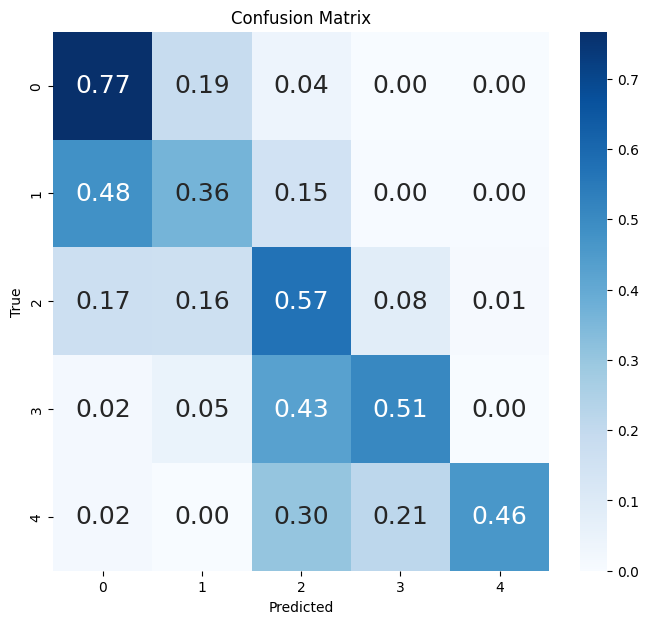

In [36]:
conf_matrix = confusion_matrix(validation_labels, validation_preds, normalize="true")

plt.figure(figsize=(8, 7))
sns.heatmap(
    conf_matrix, annot=True, cmap="Blues", annot_kws={"size": 18}, fmt=".2f"
)  # Formatting to two decimals
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()